# Aim

Attempting to implement the Support Vector Kalman method, as described at http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.672.2696&rep=rep1&type=pdf.


In [1]:
from sklearn import svm
import numpy as np
from aberrations import make_vibe_params, make_vibe_data, make_noisy_data, measurement_noise, f_1
from observer import make_kfilter, vibe_fit_freq, get_psd, predict, update, noise_filter
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from aberrations import time_id, f_sampling, f_1, times
W = int(f_sampling/f_1 * 2) # do I really understand how Nyquist works?
N = 10
steps = int(f_sampling * time_id)
times = np.arange(0, time_id, 1 / f_sampling)

In [3]:
# set up state training data
truth = make_vibe_data(N=N)
measurements = make_noisy_data(truth)

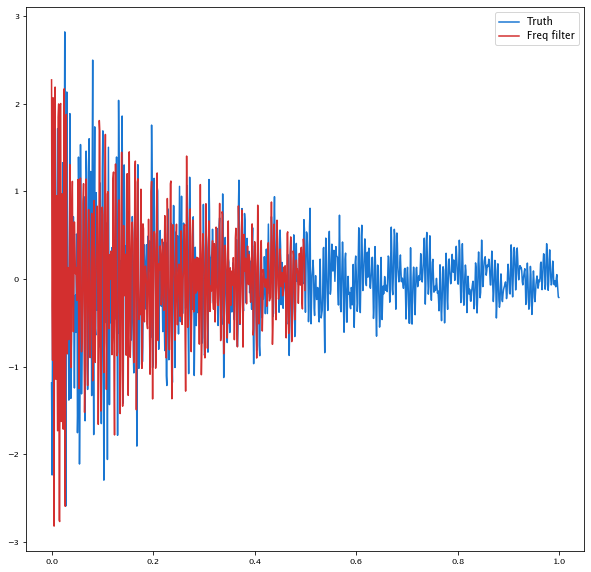

In [4]:
# first, let's run the Kalman filter for half a second normally
state, A, P, Q, H, R = make_kfilter(*vibe_fit_freq(noise_filter(get_psd(measurements)), N=N))
states_r = np.zeros((steps, state.size))
for k in range(steps//2):
    state, P = update(H, P, R, state, measurements[k])
    states_r[k] = state
    state, P = predict(A, P, Q, state)

plt.figure(figsize=(10,10))
plt.plot(times, truth, label='Truth')
plt.plot(times[:steps//2], [H.dot(state) for state in states_r[:steps//2, :]], label='Freq filter')
plt.legend()

In [ ]:
# evolve states based on this A. Note that the SVRs are getting trained but A itself isn't. May add KF for A later.
k = steps//2
state = states_r[k-1]
STATE_SIZE = 2*N
while k < steps:
    # Make the A matrix for a transition from state k to state k + 1. Assumed k > W + 1.
    if k % 100 == 0:
        x_training = states_r[k-W-2:k-1] # a row is the state at a specific timestep: size (W+1, state.size)
        y_training = states_r[k-W-1:k].T # a row is a state variable over the W timesteps: size (state.size, W+1)
        # normalize and rescale
        x_recentering = (np.min(x_training, axis=0) + np.max(x_training, axis=0))/2
        y_recentering = (np.min(y_training, axis=1) + np.max(y_training, axis=1))/2
        x_training -= np.tile(x_recentering, (W+1, 1))
        y_training -= np.repeat(y_recentering, W+1).reshape(state.size,W+1)
        
        x_scales = (np.max(x_training, axis=0) - np.min(x_training, axis=0))/2
        y_scales = (np.max(y_training, axis=1) - np.min(y_training, axis=1))/2
        
        x_training /= np.tile(x_scales, (W+1, 1))
        y_training /= np.repeat(y_scales, W+1).reshape(state.size,W+1)
        
        A = np.zeros((STATE_SIZE, STATE_SIZE))
        svk = [svm.SVR(kernel='linear',gamma='scale', C=10, epsilon=0.02)] * STATE_SIZE # to be edited!
        for i in range(STATE_SIZE):
            # help out the SVK by telling it the only state elements that matter
            # we know this is the case because we ran in frequency mode for half a second
            if i % 2 == 0:
                # we are at a position state variable
                x_training_i = x_training[:,i:i+2]
            else:
                # we are at a velocity state variable
                x_training_i = x_training[:,i-1:i+1]
            svk[i].fit(x_training_i, y_training[i])
            predictions = np.array([svk[i].predict(np.array([[1, 0]]))[0], svk[i].predict(np.array([[0, 1]]))[0]])
            if i % 2 == 0:
                A[i][i], A[i][i+1] = predictions * (y_scales/x_scales)[i:i+2]
            else:
                A[i][i-1], A[i][i] = predictions * (y_scales/x_scales)[i-1:i+1]
    state, P = update(H, P, R, state, measurements[k])
    states_r[k] = state
    state, P = predict(A, P, Q, state)
    k += 1
    
plt.figure(figsize=(10,10))
plt.plot(times, [H.dot(state) for state in states_r], label='SVK')
#plt.plot(times[steps//2:], truth[steps//2:], lab el='Truth')
plt.legend()